# Looking at the data

In [1]:
import random

import pandas as pd

data = pd.read_csv("data/eScooterDemand.csv")
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


# Convert boolean variables to binary values

In [2]:
data["Public Holiday"] = data["Public Holiday"].apply(lambda x: 1 if x == "Yes" else 0)
data["HireAvailable"] = data["HireAvailable"].apply(lambda x: 1 if x == "Yes" else 0)
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1


# One-hot encode season data

In [3]:
for season in ["Winter", "Autumn", "Spring", "Summer"]:
    data[season] = data["Season"].apply(lambda x: 1 if x == season else 0)
del data["Season"]
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Public Holiday,HireAvailable,Winter,Autumn,Spring,Summer
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,1,0,0,0
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,1,0,0,0
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,1,0,0,0
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,1,0,0,0
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,1,1,0,0,0


# Break date column into day, month and year columns

In [4]:
data["day"] = data["Date"].apply(lambda x: int(x.split("/")[0]))
data["month"] = data["Date"].apply(lambda x: int(x.split("/")[1]))
data["year"] = data["Date"].apply(lambda x: int(x.split("/")[2]))
del data["Date"]
data.head()

,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Public Holiday,HireAvailable,Winter,Autumn,Spring,Summer,day,month,year
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,1,0,0,0,1,12,2017
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,1,0,0,0,1,12,2017
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,1,0,0,0,1,12,2017
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,1,0,0,0,1,12,2017
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,1,1,0,0,0,1,12,2017


# Normalize float columns

In [5]:
from sklearn.preprocessing import minmax_scale

data[
    [
        "Temp",
        "Humidity",
        "Wind speed",
        "Visibility",
        "Dew point",
        "Sunshine",
        "Rain",
        "Snow",
        "day",
        "month",
        "year",
    ]
] = minmax_scale(
    data[
        [
            "Temp",
            "Humidity",
            "Wind speed",
            "Visibility",
            "Dew point",
            "Sunshine",
            "Rain",
            "Snow",
            "day",
            "month",
            "year",
        ]
    ]
)

## Remove hireAvailable column - if scheme is not running, it does not make sense for any scooters to be rented

In [9]:
count_when_hire_not_available = data[data["HireAvailable"] == 0]
data_when_available = data.drop(data[data["HireAvailable"] == 0].index)
del data_when_available["HireAvailable"]

## Training the model

In [10]:
from sklearn.model_selection import train_test_split

X, y = data_when_available.drop("Count", axis=1), data_when_available["Count"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.9
)  # Train on the vast majority of data but leave a bit for testing the best individual

In [11]:
from deap import base, creator, tools, gp
from operator import mul, add, sub, attrgetter, neg
# from math import log

pset = gp.PrimitiveSet("main", X.shape[1])

pset.addPrimitive(mul, 2)
pset.addPrimitive(add, 2)
pset.addEphemeralConstant("randFloat", random.random)
pset.addPrimitive(sub, 2)
pset.addPrimitive(neg, 1)
# pset.addPrimitive(pow, 2)
# pset.addPrimitive(log, 1)
# pset.addPrimitive(cos, 1)
# pset.addPrimitive(sin, 1)
# pset.addPrimitive(sqrt, 1)
# pset.addPrimitive(abs, 1)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register(
    "select",
    tools.selDoubleTournament,
    fitness_size=150,
    parsimony_size=1.4,
    fitness_first=True,
)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=3, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=attrgetter("height"), max_value=10))

pset.renameArguments(
    **dict(
        [
            (f"ARG{index}", column.lower().replace(" ", "_"))
            for (index, column) in enumerate(X.columns)
        ]
    )
)

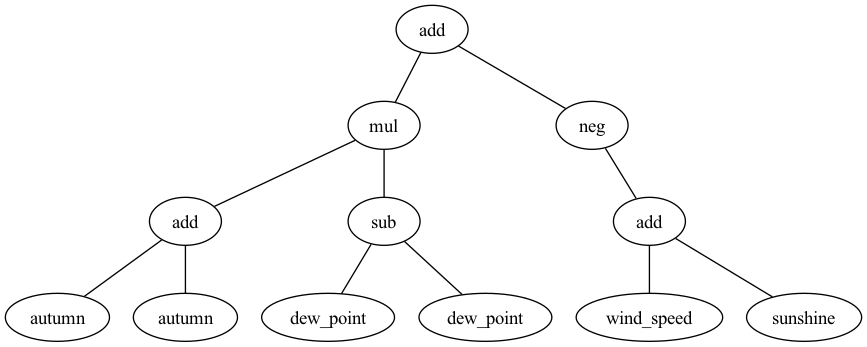

In [12]:
import pygraphviz as pgv
from IPython.display import Image

ind = toolbox.individual()

nodes, edges, labels = gp.graph(ind)
tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
Image(treePlot)

In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np


def evaluate_mse(individual, test_inputs, test_values):
    func = toolbox.compile(expr=individual)
    try:
        fitness = mean_squared_error(
            test_values, [func(*list(row)) for row in np.array(test_inputs)]
        )
    except:  # noqa E722
        return (1000000000,)
    return (fitness,)


toolbox.register("evaluate", evaluate_mse, test_inputs=X_train, test_values=y_train)

In [14]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [ ]:
from deap import algorithms

pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    cxpb=0.5,
    mutpb=0.3,
    ngen=150,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)

   	      	                              fitness                              	                      size                     
   	      	-------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg       	gen	max        	min   	nevals	std        	avg   	gen	max	min	nevals	std    
0  	500   	1.8876e+07	0  	6.54296e+09	484902	500   	3.00677e+08	44.202	0  	378	4  	500   	65.4443
1  	332   	1.49823e+07	1  	5.10804e+09	391175	332   	2.32193e+08	74.068	1  	298	6  	332   	78.4551
2  	294   	5.01596e+06	2  	8.33832e+08	378110	294   	4.37432e+07	37.878	2  	103	6  	294   	21.6135
3  	335   	1.41752e+09	3  	1.75355e+11	326944	335   	1.47497e+10	73.912	3  	128	18 	335   	14.0204
4  	318   	2.11704e+09	4  	1.75763e+11	295881	318   	1.88148e+10	72.742	4  	135	9  	318   	14.4554
5  	318   	5.9263e+08 	5  	1.66958e+11	293323	318   	8.11026e+09	84.106	5  	144	10 	318   	14.5466
6  	315   	1.93793e+11	6  	9.60823e+13	284935	315   	4.

In [ ]:
import matplotlib.pyplot as plt

gen = log.chapters["fitness"].select("gen")
_min = log.chapters["fitness"].select("min")
_max = log.chapters["fitness"].select("max")
avgs = log.chapters["fitness"].select("avg")
stds = log.chapters["fitness"].select("std")
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, _min)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

In [ ]:
indv = tools.selBest(pop, 1)[0]
print(indv)

In [ ]:
nodes, edges, labels = gp.graph(indv)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
Image(treePlot)

In [ ]:
from collections import OrderedDict
from torch import nn, from_numpy, float32

model = nn.Sequential(
    OrderedDict(
        [
            ("fc1", nn.Linear(X.shape[1], 128)),
            ("relu1", nn.ReLU()),
            ("fc2", nn.Linear(128, 64)),
            ("relu2", nn.ReLU()),
            ("fc3", nn.Linear(64, 1)),
        ]
    )
)

x = from_numpy(np.array(X_train, dtype=float32))
model(x)